In [1]:
# libraries
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import RidgeClassifier

In [2]:
for dirname, _, filenames in os.walk('/project/data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/project/data/.DS_Store
/project/data/gender_submission.csv
/project/data/test.csv
/project/data/train.csv
/project/data/.ipynb_checkpoints/dataset-checkpoint.txt


In [3]:
train = pd.read_csv('/project/data/train.csv')
test = pd.read_csv('/project/data/test.csv')
alldata = pd.concat([train, test], axis = 0, ignore_index = True)

In [4]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [5]:
print(f"The train set has {len(train)} samples and the test set has {len(test)} samples")
print(f"The whole Titanic data set has {len(alldata)} samples")

The train set has 891 samples and the test set has 418 samples
The whole Titanic data set has 1309 samples


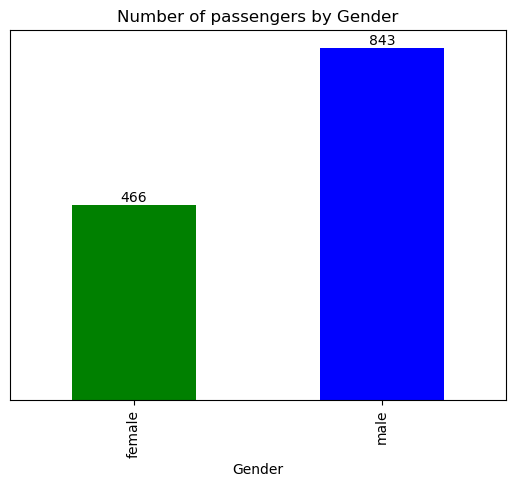

In [6]:
ax = alldata.groupby('Sex').size().plot.bar(color=['green', 'blue'])
plt.title('Number of passengers by Gender')
plt.xlabel('Gender')
plt.yticks([])
for label in ax.containers:
    ax.bar_label(label)
plt.show()

In [7]:
women_surv = len(train[(train.Sex == 'female') & (train.Survived == 1)])
total_women = len(train[train.Sex == 'female'])
women_surv_pct = women_surv / total_women
print(f"The percentage of women that survived (train set) was {women_surv_pct*100:.3f}%")

The percentage of women that survived (train set) was 74.204%


In [8]:
train.Name[:3]

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
Name: Name, dtype: object

In [9]:
alldata['title'] = alldata.Name.apply(lambda x: re.search(r',\s(.+?)\.', x).group(1))

In [10]:
alldata.title.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: title, dtype: int64

In [11]:
# Reclassify titles
alldata.loc[alldata.title.isin(['Ms', 'Mlle']), 'title'] = 'Miss'
alldata.loc[alldata.title.isin(['Mme']), 'title'] = 'Mrs'

# Rare category
rare = ['Major', 'Lady', 'Sir', 'Don', 'Capt', 'the Countess', 'Jonkheer', 'Dona', 'Dr', 'Rev', 'Col']
alldata.loc[alldata.title.isin(rare), 'title'] = 'rare'

alldata.title.value_counts()

Mr        757
Miss      264
Mrs       198
Master     61
rare       29
Name: title, dtype: int64

In [12]:
# Surnames
alldata['surname'] = alldata.Name.apply(lambda x: re.search(r'^(.+?)\,', x).group(1))
alldata.surname[:4]

0       Braund
1      Cumings
2    Heikkinen
3     Futrelle
Name: surname, dtype: object

In [13]:
### Feature that contains surnames for WCF groups
alldata['surname_WCF'] = alldata.surname

# Take out adult males but we keep boys (Master)
alldata.loc[((alldata.Sex == 'male') & (alldata.title == 'Mr'))|
             ((alldata.Sex == 'male') & (alldata.title == 'rare')), 'surname_WCF'] = np.nan

# WCF_count counts the number of passenger for each surname group (in_WCF)
alldata['WCF_count'] = alldata.groupby('surname_WCF')['surname_WCF'].transform('count')
alldata.loc[(alldata.WCF_count < 2.0 ), 'surname_WCF'] = np.nan

alldata.loc[(alldata.WCF_count >= 2.0), 'in_WCF'] = 1
alldata.loc[(alldata.WCF_count < 2.0 ), 'in_WCF'] = 0

# WCF_Survived & WCF_Died 
for surname in alldata.surname_WCF.unique():
    surv_rate = np.mean(alldata.loc[alldata.surname_WCF == surname, 'Survived'])
    if surv_rate > 0.5:
        alldata.loc[alldata.surname_WCF == surname, 'WCF_Survived'] = 1
    else:
        alldata.loc[alldata.surname_WCF == surname, 'WCF_Died'] = 1

# Fillna in the new features 
alldata[['in_WCF', 'WCF_Survived', 'WCF_Died']] = alldata[['in_WCF', 'WCF_Survived', 'WCF_Died']].fillna(0)

# Drop intermediate features no longer needed
alldata.drop(columns=['Name', 'surname', 'surname_WCF', 'WCF_count'], axis = 1, inplace = True)

In [14]:
print(f"The number of passengers sharing tickets is: {len(alldata) - len(alldata.Ticket.unique())}")


The number of passengers sharing tickets is: 380


In [15]:
alldata['family_size'] = alldata.SibSp + alldata.Parch + 1

alldata['ticket_group_count'] = alldata.groupby('Ticket')['Ticket'].transform('count')

In [16]:
print(f"Number of passenger that match family_size and ticket_group_count is: {len(alldata[alldata.family_size == alldata.ticket_group_count])}")
print(f"There's a mismatch of {len(alldata) - len(alldata[alldata.family_size == alldata.ticket_group_count])}")

Number of passenger that match family_size and ticket_group_count is: 1025
There's a mismatch of 284


In [17]:
alldata['group_size'] = alldata[['family_size', 'ticket_group_count']].max(axis = 1)
alldata['is_alone'] = alldata.group_size.apply(lambda x: 1 if x == 1 else 0)

In [18]:
alldata['fare_pp'] = alldata.Fare / alldata.ticket_group_count


In [19]:
alldata.drop('Fare', axis = 1, inplace = True)
alldata.drop('Ticket', axis = 1, inplace = True)

In [20]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PassengerId         1309 non-null   int64  
 1   Survived            891 non-null    float64
 2   Pclass              1309 non-null   int64  
 3   Sex                 1309 non-null   object 
 4   Age                 1046 non-null   float64
 5   SibSp               1309 non-null   int64  
 6   Parch               1309 non-null   int64  
 7   Cabin               295 non-null    object 
 8   Embarked            1307 non-null   object 
 9   title               1309 non-null   object 
 10  in_WCF              1309 non-null   float64
 11  WCF_Died            1309 non-null   float64
 12  WCF_Survived        1309 non-null   float64
 13  family_size         1309 non-null   int64  
 14  ticket_group_count  1309 non-null   int64  
 15  group_size          1309 non-null   int64  
 16  is_alo

In [21]:
alldata[alldata.fare_pp.isna()]

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Cabin,Embarked,title,in_WCF,WCF_Died,WCF_Survived,family_size,ticket_group_count,group_size,is_alone,fare_pp
1043,1044,NaN,3,male,60.5,0,0,NaN,S,Mr,0.0,0.0,0.0,1,1,1,1,NaN


In [22]:
alldata.groupby('Pclass')['fare_pp'].describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,323.0,33.910500,15.369762,0.0,26.550000,29.70,38.64375,128.0823
2,277.0,11.411010,2.632930,0.0,10.500000,12.35,13.00000,16.0000
3,708.0,7.329146,1.471362,0.0,7.060031,7.75,7.92500,19.9667


In [25]:
alldata.loc[alldata[alldata.fare_pp.isna()].index, 'fare_pp'] = alldata.groupby('Pclass')['fare_pp'].median()[3]

In [26]:
# train age and test age 
train_age = alldata[alldata.Age.notnull()].copy()
test_age = alldata[alldata.Age.isna()].copy()

In [27]:
# fit to the data
kmeans = KMeans(n_clusters = 4, random_state = 41)
labels_pred = kmeans.fit_predict(train_age[['Age']])

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [28]:
kmeans.cluster_centers_.flatten()


array([21.5654321 , 52.97043011, 34.10814607,  5.31989899])

In [29]:
np.argsort(kmeans.cluster_centers_.flatten())


array([3, 0, 2, 1])

In [30]:
label_dict = {label: v for v, label in enumerate(np.argsort(kmeans.cluster_centers_.flatten()))}
label_dict 

{3: 0, 0: 1, 2: 2, 1: 3}

In [32]:
labels = [label_dict[label] for label in labels_pred]

In [33]:
train_age['Age_category'] = labels


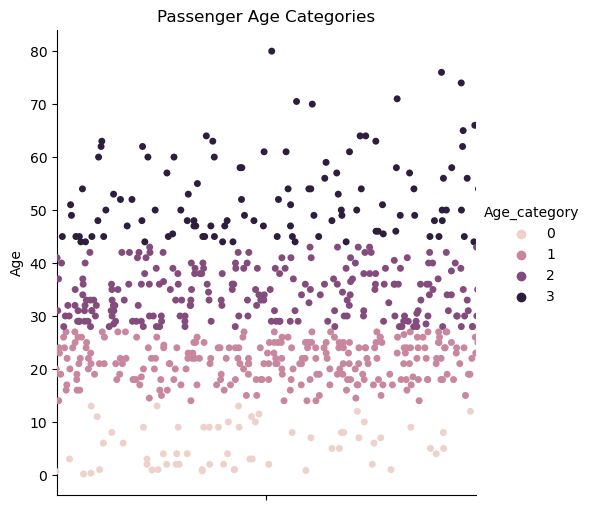

In [36]:
# Visualizing new age clusters
sns.catplot(y='Age', data=train_age, hue='Age_category', jitter=0.8)
plt.title('Passenger Age Categories')
plt.show()

In [37]:
# Survival rates by age category
train_age.groupby(['Age_category'])['Survived'].mean()

Age_category
0    0.591549
1    0.372180
2    0.407115
3    0.370968
Name: Survived, dtype: float64

In [38]:
train_age.groupby(['Age_category', 'Sex'])['Survived'].mean().unstack()


Sex,female,male
Age_category,,
0,0.617647,0.567568
1,0.747475,0.149701
2,0.797753,0.195122
3,0.794872,0.176471


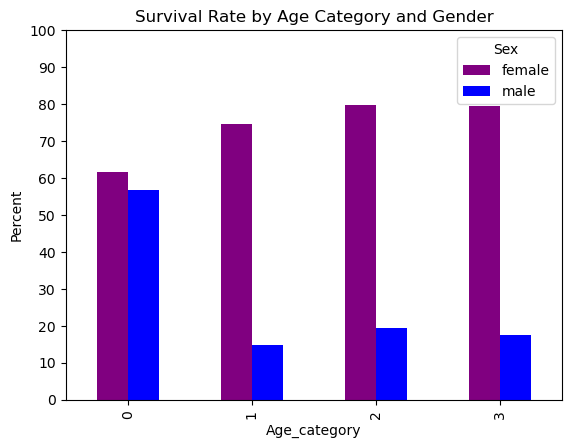

In [39]:
train_age.groupby(['Age_category', 'Sex'])['Survived'].mean().unstack().plot.bar(
color = ['purple', 'blue'])
plt.title('Survival Rate by Age Category and Gender')
plt.yticks(ticks=np.arange(0,1.1,0.1), labels=np.arange(0,110,10))
plt.ylabel('Percent')
plt.show()

In [40]:
alldata = pd.concat([alldata, train_age.Age_category], axis = 1)


In [41]:
alldata.drop(['PassengerId', 'Cabin', 'Age'], axis = 1, inplace = True)


In [42]:
alldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Survived            891 non-null    float64
 1   Pclass              1309 non-null   int64  
 2   Sex                 1309 non-null   object 
 3   SibSp               1309 non-null   int64  
 4   Parch               1309 non-null   int64  
 5   Embarked            1307 non-null   object 
 6   title               1309 non-null   object 
 7   in_WCF              1309 non-null   float64
 8   WCF_Died            1309 non-null   float64
 9   WCF_Survived        1309 non-null   float64
 10  family_size         1309 non-null   int64  
 11  ticket_group_count  1309 non-null   int64  
 12  group_size          1309 non-null   int64  
 13  is_alone            1309 non-null   int64  
 14  fare_pp             1309 non-null   float64
 15  Age_category        1046 non-null   float64
dtypes: flo

In [43]:
alldata[alldata.Embarked.isnull()]


,Survived,Pclass,Sex,SibSp,Parch,Embarked,title,in_WCF,WCF_Died,WCF_Survived,family_size,ticket_group_count,group_size,is_alone,fare_pp,Age_category
61,1.0,1,female,0,0,NaN,Miss,0.0,0.0,0.0,1,2,2,0,40.0,2.0
829,1.0,1,female,0,0,NaN,Mrs,0.0,0.0,0.0,1,2,2,0,40.0,3.0


In [44]:
alldata.Embarked.value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [45]:
alldata.loc[alldata.Embarked.isnull(), 'Embarked'] = 'S'


In [46]:
preprocessing_dummies = pd.get_dummies(alldata[['Pclass', 'Sex', 'Embarked', 'title']],
               columns = ['Pclass', 'Sex', 'Embarked', 'title'],
               prefix = ['pclass', 'sex', 'embarked', 'title'],
               drop_first= False
              )

In [47]:
alldata = pd.concat([alldata, preprocessing_dummies], axis = 1)


In [48]:
alldata.drop(['Pclass', 'Sex', 'Embarked', 'title'], axis = 1, inplace = True)


In [49]:
X = alldata.loc[alldata.Age_category.notnull(), ['SibSp', 'Parch', 'in_WCF', 'WCF_Died', 'WCF_Survived',
       'family_size', 'ticket_group_count', 'group_size', 'is_alone',
       'fare_pp', 'pclass_1', 'pclass_2', 'pclass_3',
       'sex_female', 'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S',
       'title_Master', 'title_Miss', 'title_Mr', 'title_Mrs', 'title_rare']].copy()
y = alldata.loc[alldata.Age_category.notnull(), 'Age_category'].copy()

In [50]:
scaler = StandardScaler()
fare_pp_sc_X = pd.DataFrame(scaler.fit_transform(X[['fare_pp']]), columns=['fare_pp_sc'], index = X.index)
X = pd.concat([X, fare_pp_sc_X], axis = 1).drop('fare_pp', axis=1)

In [51]:
# Testing multiple model to impute age
models = {
    'Logistic Regression': LogisticRegression(max_iter = 1000, random_state = 41),
    'Random Forest Classifier': RandomForestClassifier(random_state = 41),
    'Perceptron': Perceptron(random_state = 41),
    'SGD Classifier': SGDClassifier(random_state = 41),
    'Decision Tree Classifier': DecisionTreeClassifier(random_state = 41),
    'K-Nearest Neighbors Classifier': KNeighborsClassifier(),
    'Support Vector Machines (SVC)': SVC(random_state = 41),
    'Gaussian Naive Bayes': GaussianNB(),
    'Bagging Classifier' : BaggingClassifier(random_state = 41),
    "Gradient Boosting": GradientBoostingClassifier(random_state=41),
    'XGBC' : XGBClassifier(random_state = 41),
    'Hist Gradient Boosting Classifier' : HistGradientBoostingClassifier(random_state = 41),
    'LGBM' : LGBMClassifier(random_state = 41),
    'ADABoost' : AdaBoostClassifier(random_state=41),
    'ExtraTreesClassifier' : ExtraTreesClassifier(random_state = 41),
    'RidgeClassifier' : RidgeClassifier(random_state = 41)
}

In [52]:
scores = {}
kf = KFold(n_splits=20, random_state=41, shuffle=True)
for name, model in models.items():
    cv = cross_val_score(model, X, y, cv = kf)
    scores[name] = cv
    print(f"Using model {name} Average CV Accuracy Score is: {np.mean(scores[name])*100:.2f}% and the STD is: {np.std(scores[name])*100:.2f}%")

Using model Logistic Regression Average CV Accuracy Score is: 53.91% and the STD is: 5.03%
Using model Random Forest Classifier Average CV Accuracy Score is: 54.70% and the STD is: 6.56%
Using model Perceptron Average CV Accuracy Score is: 44.85% and the STD is: 7.44%
Using model SGD Classifier Average CV Accuracy Score is: 45.62% and the STD is: 9.37%
Using model Decision Tree Classifier Average CV Accuracy Score is: 54.22% and the STD is: 7.33%
Using model K-Nearest Neighbors Classifier Average CV Accuracy Score is: 51.85% and the STD is: 5.87%
Using model Support Vector Machines (SVC) Average CV Accuracy Score is: 57.25% and the STD is: 6.15%
Using model Gaussian Naive Bayes Average CV Accuracy Score is: 44.34% and the STD is: 4.74%
Using model Bagging Classifier Average CV Accuracy Score is: 53.26% and the STD is: 5.97%
Using model Gradient Boosting Average CV Accuracy Score is: 57.55% and the STD is: 6.61%
Using model XGBC Average CV Accuracy Score is: 57.28% and the STD is: 5.86%

In [53]:
# Fiting GBC on  X_train_a
svc = SVC(random_state = 41)
svc.fit(X, y)

SVC(random_state=41)

In [54]:
X_test_cat_age_imp =  alldata.loc[alldata.Age_category.isna(), ['SibSp', 'Parch', 'in_WCF', 'WCF_Died', 'WCF_Survived',
       'family_size', 'ticket_group_count', 'group_size', 'is_alone',
       'fare_pp', 'pclass_1', 'pclass_2', 'pclass_3',
       'sex_female', 'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S',
       'title_Master', 'title_Miss', 'title_Mr', 'title_Mrs', 'title_rare']]
# scaling fare per passenger X_test_imputation
fare_pp_sc_test_imputation = pd.DataFrame(scaler.transform(X_test_cat_age_imp[['fare_pp']]), columns =['fare_pp_sc'], index = X_test_cat_age_imp.index)
X_test_cat_age_imp = pd.concat([X_test_cat_age_imp, fare_pp_sc_test_imputation], axis = 1).drop('fare_pp', axis=1)

In [56]:
imputation_cat_age = svc.predict(X_test_cat_age_imp)


In [57]:
alldata.loc[alldata.Age_category.isnull(), 'Age_category'] = imputation_cat_age


In [58]:
alldata.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Survived            891 non-null    float64
 1   SibSp               1309 non-null   int64  
 2   Parch               1309 non-null   int64  
 3   in_WCF              1309 non-null   float64
 4   WCF_Died            1309 non-null   float64
 5   WCF_Survived        1309 non-null   float64
 6   family_size         1309 non-null   int64  
 7   ticket_group_count  1309 non-null   int64  
 8   group_size          1309 non-null   int64  
 9   is_alone            1309 non-null   int64  
 10  fare_pp             1309 non-null   float64
 11  Age_category        1309 non-null   float64
 12  pclass_1            1309 non-null   uint8  
 13  pclass_2            1309 non-null   uint8  
 14  pclass_3            1309 non-null   uint8  
 15  sex_female          1309 non-null   uint8  
 16  sex_ma

In [59]:
train_clean = alldata.loc[alldata.Survived.notnull()].copy()


In [60]:
test_clean = alldata.loc[alldata.Survived.isnull()].drop('Survived', axis = 1).copy()


In [61]:
# Split Independent and dependent variables from train_clean
X = train_clean.drop('Survived', axis = 1)
y = train_clean.Survived

In [62]:
scaler = StandardScaler()

X_fare_sc = pd.DataFrame(scaler.fit_transform(X[['fare_pp']]), columns=['fare_pp_sc'], index = X.fare_pp.index)
test_clean_fare_sc = pd.DataFrame(scaler.transform(test_clean[['fare_pp']]), columns=['fare_pp_sc'], index = test_clean.fare_pp.index)

In [63]:
X = pd.concat([X, X_fare_sc], axis = 1).drop('fare_pp', axis = 1)
test_clean = pd.concat([test_clean, test_clean_fare_sc], axis = 1).drop('fare_pp', axis = 1)

In [64]:
X.columns


Index(['SibSp', 'Parch', 'in_WCF', 'WCF_Died', 'WCF_Survived', 'family_size',
       'ticket_group_count', 'group_size', 'is_alone', 'Age_category',
       'pclass_1', 'pclass_2', 'pclass_3', 'sex_female', 'sex_male',
       'embarked_C', 'embarked_Q', 'embarked_S', 'title_Master', 'title_Miss',
       'title_Mr', 'title_Mrs', 'title_rare', 'fare_pp_sc'],
      dtype='object')

In [65]:
features = ['in_WCF', 'WCF_Died', 'WCF_Survived', 'family_size', 'group_size', 'is_alone', 'Age_category',
       'pclass_1', 'pclass_2', 'pclass_3', 'sex_female', 'sex_male',
       'embarked_C', 'embarked_Q', 'embarked_S', 'title_Master', 'title_Miss',
       'title_Mr', 'title_Mrs', 'title_rare', 'fare_pp_sc']
X = X[features].copy()

In [66]:
models = {
    'Logistic Regression': LogisticRegression(max_iter = 500, random_state = 41),
    'Random Forest Classifier': RandomForestClassifier(random_state = 41),
    'Perceptron': Perceptron(random_state = 41),
    'SGD Classifier': SGDClassifier(random_state = 41),
    'Decision Tree Classifier': DecisionTreeClassifier(random_state = 41),
    'K-Nearest Neighbors Classifier': KNeighborsClassifier(),
    'Support Vector Machines (SVC)': SVC(random_state = 41),
    'Gaussian Naive Bayes': GaussianNB(),
    'Bagging Classifier' : BaggingClassifier(random_state = 41),
    "Gradient Boosting": GradientBoostingClassifier(random_state=41),
    'XGBC' : XGBClassifier(random_state = 41),
    'Hist Gradient Boosting Classifier' : HistGradientBoostingClassifier(random_state = 41),
    'LGBM' : LGBMClassifier(random_state = 41),
    'ADABoost' : AdaBoostClassifier(random_state=41),
    'ExtraTreesClassifier' : ExtraTreesClassifier(random_state = 41)
}

In [67]:
accuracy_scores = {}

skf = StratifiedKFold(n_splits = 20, random_state = 41, shuffle = True)

for name, model in models.items():
        cv = cross_val_score(model, X, y, cv = skf)
        accuracy_scores[name] = cv
        print(f"Using the model {name} CV Av Accuracy Scores is {np.mean(accuracy_scores[name])*100:.2f}% and the std is {np.std(accuracy_scores[name])*100:.2f}%")

Using the model Logistic Regression CV Av Accuracy Scores is 85.43% and the std is 5.39%
Using the model Random Forest Classifier CV Av Accuracy Scores is 82.74% and the std is 5.66%
Using the model Perceptron CV Av Accuracy Scores is 77.90% and the std is 12.62%
Using the model SGD Classifier CV Av Accuracy Scores is 82.86% and the std is 7.34%
Using the model Decision Tree Classifier CV Av Accuracy Scores is 82.28% and the std is 5.35%
Using the model K-Nearest Neighbors Classifier CV Av Accuracy Scores is 83.63% and the std is 5.12%
Using the model Support Vector Machines (SVC) CV Av Accuracy Scores is 86.00% and the std is 5.53%
Using the model Gaussian Naive Bayes CV Av Accuracy Scores is 84.76% and the std is 5.85%
Using the model Bagging Classifier CV Av Accuracy Scores is 84.32% and the std is 5.32%
Using the model Gradient Boosting CV Av Accuracy Scores is 86.22% and the std is 4.66%
Using the model XGBC CV Av Accuracy Scores is 84.77% and the std is 5.34%
Using the model Hist

In [68]:
svc = SVC()
svc.fit(X, y)
y_hat = svc.predict(test_clean[features])
pd.DataFrame({
     'PassengerId': test.PassengerId,
     'Survived' : y_hat.astype(int)
 }).to_csv('submission-solution-3.csv', index = False)